<a href="https://colab.research.google.com/github/EnriquezAJP/CCDEPLRL_PROJECT_COM211/blob/main/FSL%20Interpreter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retraining an Image Classifier


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_image_retraining"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/image/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

## Introduction

Image classification models have millions of parameters. Training them from
scratch requires a lot of labeled training data and a lot of computing power. Transfer learning is a technique that shortcuts much of this by taking a piece of a model that has already been trained on a related task and reusing it in a new model.

This Colab demonstrates how to build a Keras model for classifying five species of flowers by using a pre-trained TF2 SavedModel from TensorFlow Hub for image feature extraction, trained on the much larger and more general ImageNet dataset. Optionally, the feature extractor can be trained ("fine-tuned") alongside the newly added classifier.

### Looking for a tool instead?

This is a TensorFlow coding tutorial. If you want a tool that just builds the TensorFlow or TFLite model for, take a look at the [make_image_classifier](https://github.com/tensorflow/hub/tree/master/tensorflow_hub/tools/make_image_classifier) command-line tool that gets [installed](https://www.tensorflow.org/hub/installation) by the PIP package `tensorflow-hub[make_image_classifier]`, or at [this](https://colab.sandbox.google.com/github/tensorflow/examples/blob/master/tensorflow_examples/lite/model_maker/demo/image_classification.ipynb) TFLite colab.


## Setup

In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
from keras import models
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.15.0
Hub version: 0.16.1
GPU is available


## Select the TF2 SavedModel module to use

For starters, use [https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4). The same URL can be used in code to identify the SavedModel and in your browser to show its documentation. (Note that models in TF1 Hub format won't work here.)

You can find more TF2 models that generate image feature vectors [here](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2).

There are multiple possible models to try. All you need to do is select a different one on the cell below and follow up with the notebook.

In [ ]:
#@title

model_name = "efficientnetv2-s" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
  "google_mobilenet_v2": "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-classification/2"
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300,
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 128)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 32#@param {type:"integer"}

Selected model: efficientnetv2-s : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2
Input size (384, 384)


## Set up the dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [ ]:
import pathlib
from google.colab import drive
drive.mount('/content/gdrive')
data_dir = "gdrive/My Drive/Colab Notebooks/Datafiles/signs"
data_dir = pathlib.Path(data_dir)

Mounted at /content/gdrive


In [ ]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=0.20,
      subset=subset,
      labels="inferred",
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1
      )

train_ds = build_dataset("training")
class_names = train_ds.class_names
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()



normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])

do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 3640 files belonging to 26 classes.
Using 2912 files for training.
Found 3640 files belonging to 26 classes.
Using 728 files for validation.


## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [ ]:
do_fine_tuning = False #@param {type:"boolean"}

In [ ]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                      kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build([None, 384, 384, 3])  # Batch input shape.
model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              20331360  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                    

In [ ]:
# print("Building model with", model_handle)
# model = tf.keras.Sequential([
#     # Explicitly define the input shape so the model can be properly
#     # loaded by the TFLiteConverter
#     tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
#     hub.KerasLayer(model_handle, trainable=True),
#     tf.keras.layers.Dropout(rate=0.2),
#     tf.keras.layers.Dense(len(class_names),
#                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
# ])
# model.build((None,)+IMAGE_SIZE+(3,))
# model.summary()

## Training the model

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
   metrics=['accuracy', 'Precision', 'Recall'])

In [ ]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=30, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/30
91/91 [==============================] - 247s 3s/step - loss: 2.7477 - accuracy: 0.2153 - precision: 0.1430 - recall: 0.4749 - val_loss: 2.0970 - val_accuracy: 0.4247 - val_precision: 0.1909 - val_recall: 0.8239
Epoch 2/30
91/91 [==============================] - 29s 324ms/step - loss: 2.0595 - accuracy: 0.4543 - precision: 0.2018 - recall: 0.8101 - val_loss: 1.7598 - val_accuracy: 0.5554 - val_precision: 0.2300 - val_recall: 0.8864
Epoch 3/30
91/91 [==============================] - 29s 322ms/step - loss: 1.7751 - accuracy: 0.5560 - precision: 0.2356 - recall: 0.8839 - val_loss: 1.6919 - val_accuracy: 0.6165 - val_precision: 0.2597 - val_recall: 0.8821
Epoch 4/30
91/91 [==============================] - 29s 316ms/step - loss: 1.6048 - accuracy: 0.6315 - precision: 0.2522 - recall: 0.9169 - val_loss: 1.4537 - val_accuracy: 0.6889 - val_precision: 0.2887 - val_recall: 0.9403
Epoch 5/30
91/91 [==============================] - 29s 318ms/step - loss: 1.5285 - accuracy: 0.6789 -

KeyboardInterrupt: 

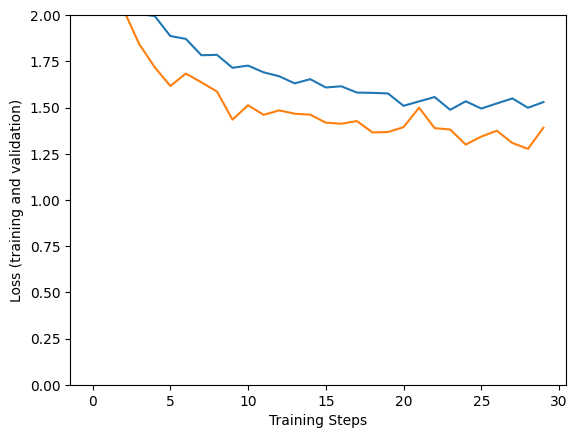

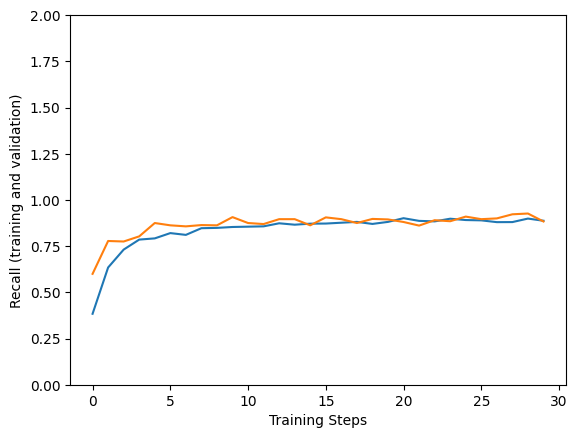

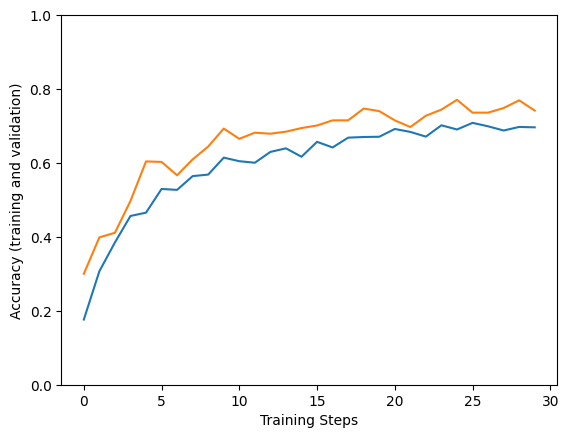

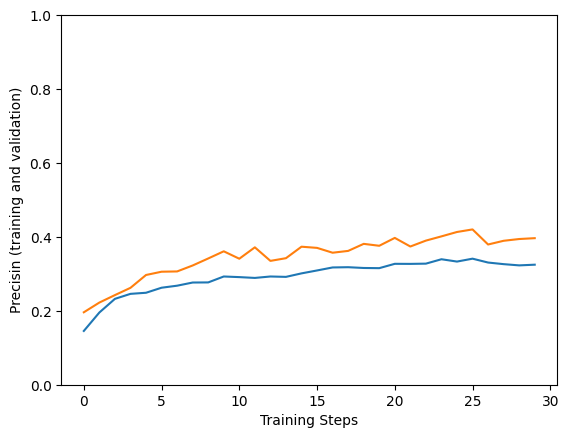

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Recall (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["recall"])
plt.plot(hist["val_recall"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

plt.figure()
plt.ylabel("Precisin (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["precision"])
plt.plot(hist["val_precision"])

Try out the model on an image from the validation data:

1/1 [==============================] - 0s 31ms/step


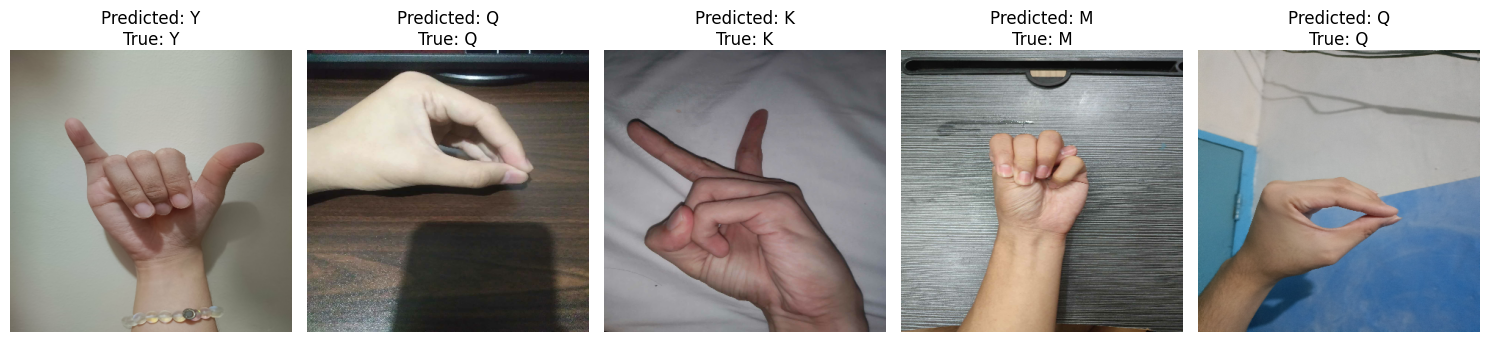

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i, (x, y) in enumerate(val_ds.take(5)):
    image = x[0, :, :, :]
    true_index = np.argmax(y[0])

    # Expand the validation image to (1, 224, 224, 3) before predicting the label
    prediction_scores = model.predict(np.expand_dims(image, axis=0))
    predicted_index = np.argmax(prediction_scores)

    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(f"Predicted: {class_names[predicted_index]}\nTrue: {class_names[true_index]}",
                     fontsize=12, loc='center', wrap=True)

plt.tight_layout()
plt.show()

Finally, the trained model can be saved for deployment to TF Serving or TFLite (on mobile) as follows.

In [ ]:
# example_input_signature = tf.TensorSpec(shape=[None, 128, 128, 3], dtype=tf.float32)

# # Create a serving function
# @tf.function(input_signature=[example_input_signature])
# def serve_model(input_data):
#     return model(input_data, training=False)

# concrete_func = serve_model.get_concrete_function()


ValueError: in user code:

    File "<ipython-input-27-b9aca56f2c7e>", line 6, in serve_model  *
        return model(input_data, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 384, 384, 3), found shape=(None, 128, 128, 3)


In [ ]:
saved_model_path = f"/tmp/saved_flowers_model_{model_name}"
tf.saved_model.save(model, saved_model_path)
print(f"Model saved at: {saved_model_path}")

Model saved at: /tmp/saved_flowers_model_efficientnetv2-s


## Optional: Deployment to TensorFlow Lite

[TensorFlow Lite](https://www.tensorflow.org/lite) lets you deploy TensorFlow models to mobile and IoT devices. The code below shows how to convert the trained model to TFLite and apply post-training tools from the [TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization). Finally, it runs it in the TFLite Interpreter to examine the resulting quality

  * Converting without optimization provides the same results as before (up to roundoff error).
  * Converting with optimization without any data quantizes the model weights to 8 bits, but inference still uses floating-point computation for the neural network activations. This reduces model size almost by a factor of 4 and improves CPU latency on mobile devices.
  * On top, computation of the neural network activations can be quantized to 8-bit integers as well if a small reference dataset is provided to calibrate the quantization range. On a mobile device, this accelerates inference further and makes it possible to run on accelerators like Edge TPU.

In [ ]:
#@title Optimization settings
optimize_lite_model = False  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 57  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_ds for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(f"/tmp/saved_flowers_model_{model_name}.tflite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

Wrote TFLite model of 82274784 bytes.


In [ ]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TFLite Interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [ ]:
#@markdown For rapid experimentation, start with a moderate number of examples.
num_eval_examples = 50  #@param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_ds
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TFLite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TFLite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

TFLite model agrees with original model on 50 of 50 examples (100%).
TFLite model is accurate on 49 of 50 examples (98%).


In [ ]:
saved_model_dir = f"/tmp/saved_flowers_model_{model_name}"

